In [131]:
import numpy as np
import pandas as pd
import timeit
import time
import json
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from word_match import word_match


In [2]:
survey_path_1 = '/home/matt_valley/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/AI_survey_data/2017 to mid 2018 comments.csv'
survey_path_2 = '/home/matt_valley/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/AI_survey_data/2018 to mid 2019 comments.csv'

df = pd.read_csv(survey_path_1, header=1)
df2 = pd.read_csv(survey_path_2, header=1)

print(len(df))
df = df.dropna(how='any')
print(len(df))

df = df.rename(columns={"Comment": "text"})
df.head()

text_clean = [len(t) for t in df.text.values]


# load spacy model

model = 'en_core_web_sm' # for testing on laptop
#model = 'en_core_web_lg'
#model = 'en_vectors_web_lg' # many more words
nlp = spacy.load(model)
#sentencizer = nlp.create_pipe("sentencizer")
#nlp.add_pipe(sentencizer)

88978
86080


In [3]:
start_time = timeit.default_timer()

match = word_match()
match_df = pd.DataFrame()
for t,text in enumerate(df['text']):
    doc = nlp(text)
    out_df = match.match_topics(t, doc)
    match_df = match_df.append(out_df)
    
match_df.reset_index(drop=True, inplace=True)

process_time = timeit.default_timer() - start_time
print(str(len(df)) + ' submissions, query took ' + str(process_time) + ' seconds')

ERROR WITH SPACY TOKEN MATCHING!  schedule.
ERROR WITH SPACY TOKEN MATCHING!  admin is always
ERROR WITH SPACY TOKEN MATCHING!  patient.
ERROR WITH SPACY TOKEN MATCHING!  staff is
ERROR WITH SPACY TOKEN MATCHING!  communication,
ERROR WITH SPACY TOKEN MATCHING!  communicate.
ERROR WITH SPACY TOKEN MATCHING!  employees.
ERROR WITH SPACY TOKEN MATCHING!  team work
ERROR WITH SPACY TOKEN MATCHING!  Team work
ERROR WITH SPACY TOKEN MATCHING!  facility.
ERROR WITH SPACY TOKEN MATCHING!  staff.
ERROR WITH SPACY TOKEN MATCHING!  co workers
ERROR WITH SPACY TOKEN MATCHING!  co-workers
ERROR WITH SPACY TOKEN MATCHING!  staff.
ERROR WITH SPACY TOKEN MATCHING!  staff.  
ERROR WITH SPACY TOKEN MATCHING!  Team work
ERROR WITH SPACY TOKEN MATCHING!  Co workers
ERROR WITH SPACY TOKEN MATCHING!  resident.
ERROR WITH SPACY TOKEN MATCHING!  schedule.
ERROR WITH SPACY TOKEN MATCHING!  employees.
ERROR WITH SPACY TOKEN MATCHING!  staff.
ERROR WITH SPACY TOKEN MATCHING!  staff.  
ERROR WITH SPACY TOKEN MAT

In [7]:
print(len(df))
print(len(match_df))
pd.to_pickle(match_df, '~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/match_df.pkl')

86080
62920


In [3]:
match_df = pd.read_pickle('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/match_df.pkl')

In [5]:
### LOAD EMBEDDING MODEL

model = 'en_vectors_web_lg'
nlp_vec = spacy.load(model)

y_vec = []
topics = match_df['topic'].unique()
for topic in topics:
    y_doc = nlp(topic)
    y_vec.append(y_doc.vector)

In [6]:
y_vec = np.array(y_vec)
y_vec.shape

(16, 96)

In [11]:
# BUILD CONTEXT VECTORS

X = []
for n,text in enumerate(match_df['context_span'].values):
    X.append(nlp(text).vector)
X = np.array(X)
print(X.shape)

(62920, 96)


In [17]:
# dimensionality reduce

pca = PCA(n_components=20, whiten=True, random_state=42)
pca.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
    svd_solver='auto', tol=0.0, whiten=True)

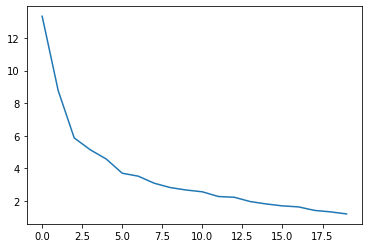

In [18]:
plt.plot(pca.explained_variance_)

In [34]:
'''
do tfidf
'''

all_tfidf = []
topics = match_df['topic'].unique()
for topic in topics:
    temp_df = match_df[match_df['topic']==topic]
    data = [sent for sent in temp_df.comment_text]
    
    n_features = 1000
    n_components = 12
    n_top_words = 8
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')

    t0 = time.time()
    tfidf = tfidf_vectorizer.fit_transform(data)

    feature_array = np.array(tfidf_vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]
    
    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    print(topic)
    print(top_n)
        
    all_tfidf.append(tfidf)
    print("done in %0.3fs." % (time.time() - t0))


Recognition
['cost' 'greatly' 'living' 'raise' 'believe' 'appreciate' 'staff'
 'finding' 'financial' 'field']
done in 0.105s.
Schedule
['rates' 'filling' 'called' 'higher' 'better' 'difference' 'loved'
 'morale' 'consider' 'huge']
done in 0.113s.
Benefits and leave
['salary' 'benefits' 'yes' 'feels' 'fmla' 'flu' 'floor' 'flexible'
 'flexibility' 'flex']
done in 0.191s.
Customers
['rehab' 'don' 'department' 'administrator' 'year' 'reason' 'example'
 'management' 'long' 'patients']
done in 0.955s.
Staffing level
['salary' 'fair' 'new' 'previous' 'old' 'gets' 'hired' 'hire' 'employees'
 'people']
done in 0.663s.
Quality of care
['living' 'memory' 'question' 'supportive' 'levels' 'services' 'assisted'
 'skilled' 'campus' 'work']
done in 0.149s.
Co-workers/teamwork
['managers' 'does' 'line' 'facility' 'staff' 'members' 'respect' 'level'
 'voice' 'consideration']
done in 0.857s.
Pay
['higher' 'pay' 'yes' 'far' 'filled' 'figure' 'field' 'felt' 'feels'
 'feeling']
done in 0.279s.
Support and r

In [102]:
from scipy.sparse import csr_matrix
X = np.empty((0,all_tfidf[0].shape[1]), dtype=all_tfidf[0].dtype)
y = np.empty((0))
for t,topic_vecs in enumerate(all_tfidf):
    print(topic_vecs.shape)
    print(X.shape)
    X = np.append(X,topic_vecs.toarray(), axis=0)
    y = np.append(y,np.ones(topic_vecs.shape[0])*t, axis=0)
print(X.shape)
print(y.shape)


(1327, 1000)
(0, 1000)
(935, 1000)
(1327, 1000)
(3068, 1000)
(2262, 1000)
(12106, 1000)
(5330, 1000)
(9101, 1000)
(17436, 1000)
(1850, 1000)
(26537, 1000)
(13335, 1000)
(28387, 1000)
(4538, 1000)
(41722, 1000)
(1280, 1000)
(46260, 1000)
(8369, 1000)
(47540, 1000)
(1887, 1000)
(55909, 1000)
(1205, 1000)
(57796, 1000)
(727, 1000)
(59001, 1000)
(2023, 1000)
(59728, 1000)
(392, 1000)
(61751, 1000)
(777, 1000)
(62143, 1000)
(62920, 1000)


In [134]:
logit = LogisticRegression(class_weight='balanced', 
                           random_state=42, 
                           multi_class='multinomial',
                           verbose=1,
                           max_iter=1000)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    logit.fit(X_train, y_train)
    y_pred = logit.predict((X_test))
    
    print('accuracy = ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('balenced accuracy = ' + str(metrics.balanced_accuracy_score(y_test, y_pred)))
    print('macro precision = ' + str(metrics.precision_score(y_logit.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.4s finished


accuracy = 0.9107596948506039
balenced accuracy = 0.9087941800404082
macro precision = 0.8260942729841446
recall score = 0.9087941800404082
accuracy = 0.9109980928162746
balenced accuracy = 0.9004415501528198
macro precision = 0.8236055784284785
recall score = 0.9004415501528198
accuracy = 0.9082167832167832
balenced accuracy = 0.8976723484107868
macro precision = 0.8265253862108151
recall score = 0.8976723484107868
accuracy = 0.9092498410680229
balenced accuracy = 0.8993184280490979
macro precision = 0.8166121138673523
recall score = 0.8993184280490979
accuracy = 0.9051176096630642
balenced accuracy = 0.8972589460831892
macro precision = 0.8112629571835094
recall score = 0.8972589460831892
(56628, 1000) (6292, 1000) (56628,) (6292,)


In [ ]:
y_pred = logit.predict((X_test))
print('accuracy = ' + str(metrics.accuracy_score(y_test, y_pred)))
print('balenced accuracy = ' + str(metrics.balanced_accuracy_score(y_test, y_pred)))
print('macro precision = ' + str(metrics.precision_score(y_test, y_pred,
                           average='macro')))
print('recall score = ' + str(metrics.recall_score(y_test, y_pred,
                           average='macro')))

In [ ]:
test, y_pred,
                               average='macro')))
    print('recall score = ' + str(metrics.recall_score(y_test, y_pred,
                               average='macro')))
    
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)